# Short tutorial for the SoilHOMC model

This notebooks aims to give a general view of how to write the input file, run the `SoilHOMC` model from python, by calling the terminal command prompt, and display its results. The script is divided in three sections:
    
    1. Input file construction
    2. Run the SoilHOMC model
    3. Load the model results
    4. Display and understand the results
    
Last update: May, 2021\
Author: Sebastián Aedo Quililongo (slaedo@uc.cl)
___

## Import libraries and set working directory

In [1]:
from scipy.io import FortranFile # Needed to import the SoilHOMC binary files
import matplotlib.pylab as plt   # Needed to plot the results
import numpy as np               # Needed to handle the inputs and outputs information
import os                        # Needed to run the model from the command prompt

dirname = os.getcwd()            # Set working directory

## 1. Input file
The input file must contain the following information: 

###### a) Model identification
    1. Model name  : The model name must match the name of the input file as model_name.dat
                     This notebook adds the .dat extension automatically
###### b) Soil parameters
    2. fsa         : Sand mass fraction in (g/g)
    3. fcl         : Clay mass fraction in (g/g)
    4. pb          : Soil bulk density in (kg/m3)
    5. Rp          : Volumetric pore radius in (mm). According to Aedo & Bonilla (2021), if there is no information
                     about this value, set 1.5 mm 
###### c) Initial conditions
    6. T0          : Initial soil temperature in (°C)
    7. th0         : Initial soil water content in (cm3/cm3)
    8. OM0         : Initial soil organic matter content in (g/g)
###### d) Wildfire parameters
    9. WF          : Flame temperature in (°C). Note that the model considers a constant temperature
    10. tf         : Wildfire duration in (h). This value represents the duration where the flame is above the soil 
###### e) Solver parameters
    11. L          : Soil profile length to simulate in (m). The model considers a no-flux condition at the bottom of
                     the profile, so if the profile is not depth enough, heat will accumulate at the bottom. Be sure to
                     define a depth that is not affected by the heat front
    12. dx         : Node spacing in (m)
    13. dt_cor     : Time step corrector. The time step of the simulation is defined by the soil properties (Aedo &
                     Bonilla, 2021), but this value could raise numerical unstabilities, so a factor <1 could be needed.

In [2]:
# a) Model identification
model = 'Soil1'   # The model name must match the name of the input file, including its extension
                  # Thisnotebook adds the .dat extension at the end of this cell

    
# b) Soil parameters
fsa = 0.15        # Sand mass fraction in (g/g)
fcl = 0.20        # Clay mass fraction in (g/g)
pb = 1330         # Soil bulk density in (kg/m3)
Rp = 1.5e-3       # Volumetric pore radius in (mm). If there is no information, set 1.5 mm 


# c) Initial conditions
T0 = 16.0         # Initial soil temperature in (°C)
th0 = 0.17        # Initial soil water content in (cm3/cm3)
OM0 = 0.08        # Initial soil organic matter content in (g/g)

    
# d) Wildfire parameters
WF = 635         # Flame temperature in (°C)
tf = 1           # Wildfire duration in (h)


# e) Solver parameters
L = 1            # Depth of the simulated soil profile in (m)
dx = 0.5/100     # Spacing between nodes (m)
dt_cor = 0.01    # Time step corrector


## Add the .dat extension to the model name
model_file = model+'.dat'
print('Model name: '+model)
print('Input file: '+model_file)

## Build the input file location
fname = dirname+'\\'+model_file
print('Input file location: '+fname)

## Build the inputs list and save as .dat
inputs = [model_file,fsa,fcl,pb,Rp,T0,th0,OM0,WF,tf,L,dx,dt_cor]
np.savetxt(fname,inputs,fmt="%s")

Model name: Soil1
Input file: Soil1.dat
Input file location: E:\git\SoilHOMC\Example\Soil1.dat


In [3]:
print('Check inputs:')
print(np.array([['Model','fsa','fcl','pb','Rp','T0','th0','OM0','WF','tf','L','dx','dt_corr'],inputs,['-','g/g','g/g','kg/m3','m','°C','cm3/cm3','g/g','°C','h','m','m','-']]).T)

Check inputs:
[['Model' 'Soil1.dat' '-']
 ['fsa' '0.15' 'g/g']
 ['fcl' '0.2' 'g/g']
 ['pb' '1330' 'kg/m3']
 ['Rp' '0.0015' 'm']
 ['T0' '16.0' '°C']
 ['th0' '0.17' 'cm3/cm3']
 ['OM0' '0.08' 'g/g']
 ['WF' '635' '°C']
 ['tf' '1' 'h']
 ['L' '1' 'm']
 ['dx' '0.005' 'm']
 ['dt_corr' '0.01' '-']]


## 2. Run the model

In [4]:
run = 'cmd /c "SoilHOMC.exe < '+fname+' > '+model+'.out"'
print('Command executed: ' +run)
p = os.system(run)

Command executed: cmd /c "SoilHOMC.exe < E:\git\SoilHOMC\Example\Soil1.dat > Soil1.out"


## 3. Load the model results
The `SoilHOMC` model has two outputs distributed in time and space:

    - Soil temperature profile evolution
    - Soil organic matter content profile evolution
    
The outputs file name is the model name. The file extensions are .T for temperature and . SOM for soil organic matter content. Files must be read with the `scipy.io.FortranFile` module. Each file contains three main entrances that are read by line:

    - nx, nt : (int) Number of elements and number of time steps
    - dx, dt : (float) Node spacing and time step
    - result : (array) A list containing the complete result of temperature or SOM profile evolutions. This array must
                       be reshaped to nx rows and nt columns. In this way, each row will represent one point in space
                       and each column will represent one instance in time.

With this information, the space and temporal arrays can be constructed to plot profiles or time series.

### a) Load temperature profiles

In [5]:
file = FortranFile(model+'.T', 'r')
nx,nt = file.read_reals(dtype='int32')
dx,dt = file.read_reals(dtype='float64')
T = file.read_reals(dtype='float64')
T = T.reshape(nx,nt)

### b) Load SOM profiles

In [6]:
file = FortranFile(model+'.SOM', 'r')
nx,nt = file.read_reals(dtype='int32')
dx,dt = file.read_reals(dtype='float64')
SOM = file.read_reals( dtype='float64')
SOM = SOM.reshape(nx,nt)

### c) Build space and temporal arrays

In [7]:
t = np.linspace(0,dt*nt,nt)
x = np.linspace(0,dx*nx,nx)

## 4. Display and understand the results

There are two interesting results (not the only ones) to analyze:

    - Soil temperature or SOM evolution of one point in space of the soil profile
    - Soil temperature or SOM profile at a specific time

In [8]:
# Here I define three depths and two times to plot
dp = [0,2,4]           # Indices for the x array
ts = [int(nt/2),nt-1]  # Indices for the t array

### a) Soil temperature evolution

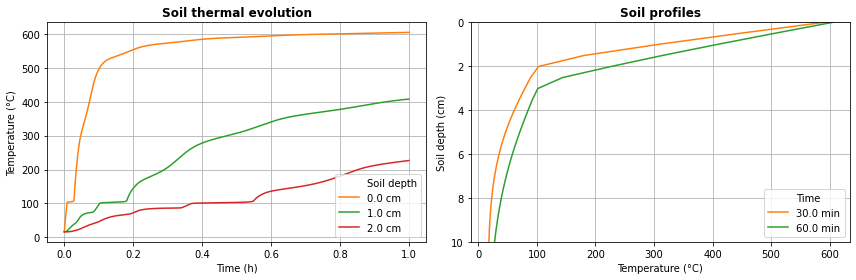

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Soil thermal evolution',fontweight='bold')
plt.grid()
plt.plot([],[],alpha=0,label='Soil depth')
for i in range(len(dp)):
    plt.plot(t,T[dp[i],:],label=str(round(x[dp[i]]*100,1))+' cm')
plt.xlabel('Time (h)')
plt.ylabel('Temperature (°C)')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Soil profiles',fontweight='bold')
plt.grid()
plt.plot([],[],alpha=0,label='Time')
for i in range(len(ts)):
    plt.plot(T[:,ts[i]],100*x,label=str(round(t[ts[i]]*60,0))+' min')
plt.legend(loc='best')
plt.ylim(10,0)
plt.xlabel('Temperature (°C)')
plt.ylabel('Soil depth (cm)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

### b) SOM evolution

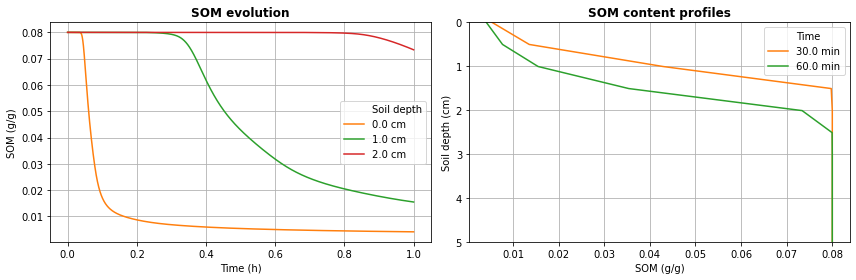

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('SOM evolution',fontweight='bold')
plt.grid()
plt.plot([],[],alpha=0,label='Soil depth')
for i in range(len(dp)):
    plt.plot(t,SOM[dp[i],:],label=str(round(x[dp[i]]*100,1))+' cm')
plt.xlabel('Time (h)')
plt.ylabel('SOM (g/g)')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('SOM content profiles',fontweight='bold')
plt.grid()
plt.plot([],[],alpha=0,label='Time')
for i in range(len(ts)):
    plt.plot(SOM[:,ts[i]],100*x,label=str(round(t[ts[i]]*60,0))+' min')
plt.legend(loc='best')
plt.ylim(5,0)
plt.xlabel('SOM (g/g)')
plt.ylabel('Soil depth (cm)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 5. Miscellaneous
If you read the .dat file you will find the input file for the `SoilHOMC` model, and in the .out you will find the outputs displayed if the model was run in the command prompt.